# А/А-тест. Проверка системы сплитирования

<div style="border:solid black 1.5px; padding: 20px">

**Заказчик** - Команда ML

---

**Об исследовании:**

Команда ML разработала новый алгоритм рекомендаций в новостной ленте приложения. Суть нового алгоритма заключается в следующем:

> _В новостной ленте будут появляться посты, которые оценили (лайкнули) похожие на пользователя посетители_


*_Даты проведенных тестов:_*

>- А/А тест проводился с '2023-05-24' по '2023-05-30'.
>- А/В тест проводился с '2023-05-31' по '2023-06-06'.

---

**Цель исследования:**

Оценить воздествие нового алгоритма на пользователей, сделает ли он приложение приятнее и удобнее для конечного потребителя.

---

**Метод оценки удовлетворенности потребителя:**

Удовлетворенность потребителя будет оценится через CTR лайков к просмотрам (то есть изменения соотношения числа лайков, выставленных пользователем, к числу его просмотров).
    
---

**О группах:**

Всего пользователи в логах данных разделены на 5 эксперементальных групп.
    
---

**Задача:** - Выполнить симуляцию, словно было проведено 10000 А/А-тестов. На каждой итерации необходимо сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

---

**План исследования:**

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

## Импорт библиотек и настройка тетради

In [1]:
# импорт необходимых библиотек
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set(style ='ticks')
import numpy as np
from scipy import stats as st
import math as mth
from math import factorial
import statsmodels.api as sm 
from read_db.CH import Getch
import pandahouse

In [2]:
# настройка тетради
# отключаю системные предупреждения
import warnings
warnings.filterwarnings('ignore')

# помощь в отображении данных
pd.set_option('display.max_columns', None) # отображение всех столбцов
pd.set_option('display.max_colwidth', None) # отображение данных в столбцах, даже если они слишком длинные

In [3]:
# извлечение из кликхауса необходимых для исследования данных
data = Getch(''' SELECT exp_group, 
                        user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views as ctr
                FROM simulator_20230620.feed_actions 
                WHERE toDate(time) between '2023-05-24' and '2023-05-30'
                        and exp_group in (2,3)
                GROUP BY exp_group, user_id
''').df

## Знакомство с данными

In [4]:
# выгружаю информацию о группах
data.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [5]:
# проверка корректности данных
data.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [6]:
# проверка на явные дубликаты
data.duplicated().sum()

0

In [7]:
total_a = data.query('exp_group == "2"')['user_id'].count()
total_b = data.query('exp_group == "3"')['user_id'].count()
print('Разница между группами 2 и 3 составляет:', abs(total_a - total_b))
print('Численность пользователей теста:', abs(total_a + total_b))

Разница между группами 2 и 3 составляет: 89
Численность пользователей теста: 17049


In [8]:
# проверка, есть ли пользователи, попавшие в обе группы
double_users = np.intersect1d(data.query('exp_group == "2"')['user_id'].unique(),
               data.query('exp_group == "3"')['user_id'].unique()) 
print('Количество пользователей попавших в оба теста:', len(double_users))

Количество пользователей попавших в оба теста: 0


<div style="border:solid black 0.5px; padding: 20px">

На основании выведенных данных можно сделать сделующие заключения:
- группы разделены примерно одинаково, 8480 юзеров во второй группе, против 8569 узеров во второй группе. Разница между группами составляет 89 пользователей.
- расчет CTR для каждого юзера сработал корректно.
- явные дубликаты отсутствуют.
- дублирования пользователей в группах нет.


Что "пощупать" данные, построю гистограмму распределения CTR пользователей из двух групп, чтобы, пока, чисто внешне посмотреть, имеются ли какие-то существенные различия между ними.

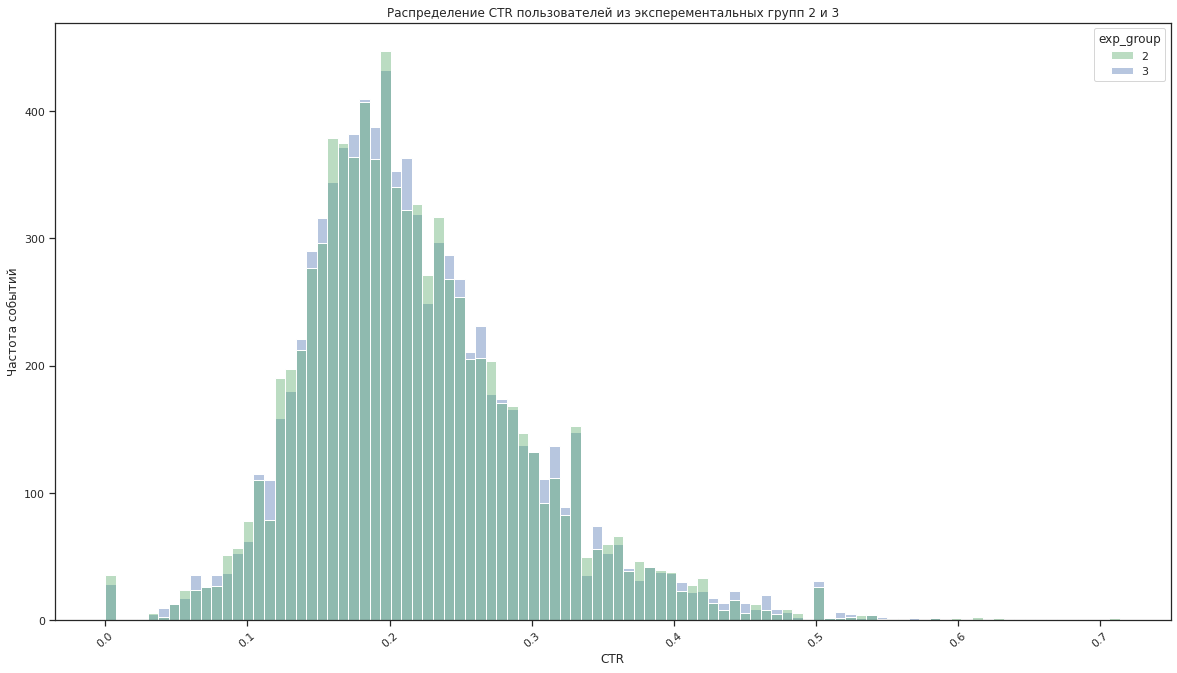

In [9]:
plt.figure(figsize=(20,11))

sns.histplot(data=data, 
             x='ctr', 
             hue='exp_group', 
             alpha = 0.4,
             palette = ['g','b'],
             kde=False)
plt.xticks(rotation=40)
plt.title('Распределение CTR пользователей из эксперементальных групп 2 и 3')
plt.xlabel('CTR')
plt.ylabel('Частота событий');

При изучении гистрограммы распределения CTR пользователей из двух групп можно заметить, что каких-то ярковыраженых различий нет, то есть пользователи по группам, с высокой долей вероятности, распределены равномерно.

Так это или нет, необходимо подтвердить в дальнейшем анализе.

## Т-тест для имеющихся групп

Как позволяет нам предположить гистограмма распределения CTR пользователей из 2 и 3 группы, пользователи распределены равномерно.
Попробую это подтвердить или опровергнуть при помощи Т-теста.

Так как t-тест сравнивает два средних значения в выборках, то гипотезы будут звучать следующим образом:

Н₀(нулевая гипотеза) - Средние значения CTR двух эксперементальных групп _не имеют_ статистически значимых различий.

Н1₁(альтернативная гипотеза - - Средние значения CTR двух эксперементальных групп _имеют_ статистически значимые различия.

In [10]:
alpha = .05 # критические уровень значимости

results = st.ttest_ind(
    data[data.exp_group == 2].ctr, # данные о CTR пользователей из группы 2
    data[data.exp_group == 3].ctr, # данные о CTR пользователей из группы 3
    equal_var=False) # использую значение equal_var=False, что предполагает неравные дисперсии, так как нельзя доказать обратное

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.45969873156477636
Не получилось отвергнуть нулевую гипотезу


<div style="border:solid black 0.5px; padding: 20px">

**Вывод по t-тесту:**

Не получилось отвергнуть нулевую гипотезу о том, что статистически значимой разницы между средними значениями CTR из двух групп нет.

По проведенному тесту тоже возможно предположить, что пользователи по группам распределены равномерно.

## Симуляция 10000 А/А-тестов

Чтобы подтвердить или опровергнуть ранее сформированные выводы, проведу симуляцию А/А-теста, который был проведен 10000 раз по подвыборкам, состоящим из 500 пользователей. После этой симуляции проверим как распределился получившийся p-value.

Решение, естетственно, через цикл.

In [11]:
p_values = [] # список, куда будут добавляться, рассчитанные в результате симуляции АА-теста, значения p-value


for i in range(10000): # задаем число повторений цикла
    # формируем подвыборки из основного датафрейма по 500 человек
    group_1 = data[data.exp_group == 2].sample(500, replace=True) 
    group_2 = data[data.exp_group == 3].sample(500, replace=True)
    # добавляем в созданный список рассчитанные значения p-value
    p_values.append(st.ttest_ind(group_1.ctr, group_2.ctr, equal_var=False).pvalue)

Выполню построение гистограммы распределения, чтобы визуально увидеть как расплелены значения p-value, рассчитанные в ходе симуляции.

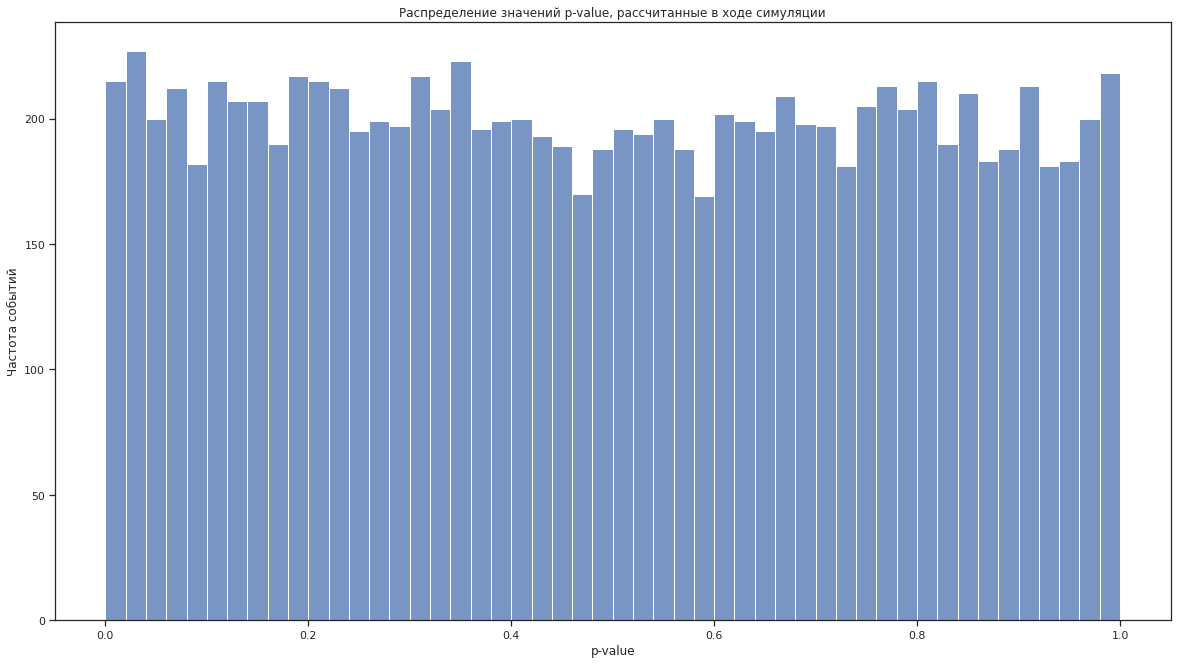

In [12]:
plt.figure(figsize=(20,11))

sns.histplot(p_values, bins = 50)
plt.title('Распределение значений p-value, рассчитанные в ходе симуляции')
plt.xlabel('p-value')
plt.ylabel('Частота событий');

<div style="border:solid black 0.5px; padding: 20px">

**Вывод по гистограмме распределения**
На гистограмме видно, что значения p-value, в целом, распределены равномерно.
    
Выполню рассчет для определения процента случаев, в которых значение p-value, рассчитанное в ходе симмуляции А/А-теста оказалось меньше или равно критическому уровню значимости alpha = 0.05

In [13]:
count = 0

for i in p_values:
    if i <= 0.05:
        count = count + 1

print('В', (count / len(p_values)) * 100,'% случаев значение p-value меньше либо равно  критическому уровню значимости alpha = 0.05')

В 5.42 % случаев значение p-value меньше либо равно  критическому уровню значимости alpha = 0.05


<div style="border:solid black 0.5px; padding: 20px">
    
## Вывод по исследованию

    
Главной задачей текущего исследования было проверить работу системы сплитирования групп на корректность. 

По результатам выполненных расчетов можно сделать вывод, что _**система сплитирования пользователей по группам сработала корректно**_.

Это подтверждают следующие выводы, сформированные в ходе исследования:

- Внешне гистограмма распределения значение CTR в двух группах не выявила критических различий.
- Т-тест не смог опровергнуть нулевую гипотезу о том, что статистически значимой разницы между средними значениями CTR из двух групп нет.
- Значения p-value, полученные в ходе 10000 симуляций А/А-теста распределены равномерно.
- В примерно 5 % случаев значение p-value, рассчитанные в ходе симуляции А/А-теста, меньше либо равно критическому уровню значимости alpha = 0.05.